# Supervised data compression via linear discriminant analysis

In [3]:
import sys
sys.path.append('../tools')

In [47]:
from plot_tools import plot_decision_regions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

    1. Standardize the d -dimensional dataset ( d is the number of features).

In [9]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

    2. For each class, compute the d -dimensional mean vector.
Each mean vector $m_i$ stores the mean feature value $\mu_m$ with respect to the sample class *i*.
$$ m_i = \frac{1}{n_i} \Sigma_{x \in D_i}^c x_m $$

In [15]:
np.set_printoptions(precision=4)

In [18]:
mean_vecs = []
for label in range(1,4):
    mask = np.array(y_train==label)
    mean_vecs.append(np.mean(X_train_std[mask], axis=0))
    print 'MV %s: %s\n' % (label, mean_vecs[label-1])

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



    3.
Construct the between-class scatter matrix S<sub>B</sub> and the within-class scatter matrix S<sub>w</sub>. <br />
$ S_W = \Sigma_{i=1}^c S_i $

$ S_i = \Sigma_{x \in D_i}^c (s-m_i)(x-m)^T $

In [19]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1,4), mean_vecs):
    mask = np.array(y==label)
    class_scatter = np.zeros((d,d))
    for row in X[mask]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

print 'Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1])

Within-class scatter matrix: 13x13


$
\Sigma_i = \frac{1}{N_i} S_W = \frac{1}{N_i} \Sigma_{x \in D_i}^c (x-m_i)(x-m_i)^T
$

In [20]:
d = 13 # number of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    mask = np.array(y_train==label)
    class_scatter = np.cov(X_train_std[mask].T)
    S_W += class_scatter
print 'Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1])

Scaled within-class scatter matrix: 13x13


$ S_B = \Sigma_{i=1}^c N_i (m_i-m)(m_i-m)^T $ <br />
**m** is the overall mean

In [22]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 # number of features
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    mask = np.array(y==(i+1))
    n = X[mask, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print 'Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1])

Between-class scatter matrix: 13x13


###### Selecting linear discriminants for the new feature subspace
    4.
Compute the eigenvectors and corresponding eigenvalues of the matrix $S_w^{-1}S_B$.

In [23]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

    5. Choose the k eigenvectors that correspond to the k largest eigenvalues to construct a d x k -dimensional
    transformation matrix W; the eigenvectors are the columns of this matrix.

In [26]:
eigen_pairs = [ (np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse=True)
print 'Eigenvalues in decreasing order:\n'
for eigen_val in eigen_pairs:
    print eigen_val[0]

Eigenvalues in decreasing order:

643.015384346
225.086981854
6.15579960812e-14
6.09154892925e-14
3.5527136788e-14
2.71387644836e-14
2.27754346089e-14
2.27754346089e-14
2.22424692302e-14
8.64167807188e-15
8.64167807188e-15
4.98929647176e-15
3.9153205942e-15


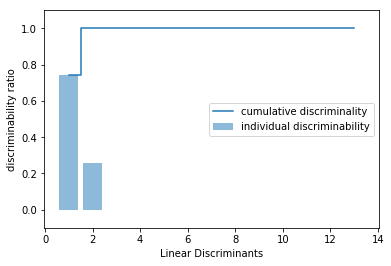

In [29]:
tot = sum(eigen_vals.real)
discr = [ (i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=.5, align='center', label='individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative discriminality')
plt.ylabel('discriminability ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-.1, 1.1])
plt.legend(loc='best')
plt.show()

    6. Project the samples onto the new feature subspace using the transformation matrix W.

In [30]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print 'Matrix W:\n %s' % w

Matrix W:
 [[-0.0707  0.3778]
 [ 0.0359  0.2223]
 [-0.0263  0.3813]
 [ 0.1875 -0.2955]
 [-0.0033 -0.0143]
 [ 0.2328 -0.0151]
 [-0.7719 -0.2149]
 [-0.0803 -0.0726]
 [ 0.0896 -0.1767]
 [ 0.1815  0.2909]
 [-0.0631 -0.2376]
 [-0.3794 -0.0867]
 [-0.3355  0.586 ]]


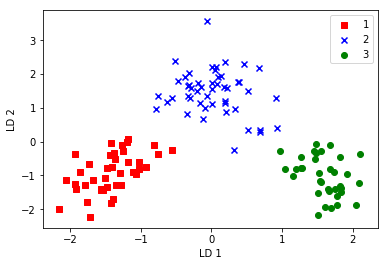

In [33]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    mask = np.array(y_train==l)
    plt.scatter(X_train_lda[mask, 0],
               X_train_lda[mask, 1]*-1, c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.show()

# LDA via scikit-learn

In [34]:
from sklearn.lda import LDA

In [35]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [68]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max()+1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        mask = np.array(y==cl)
        plt.scatter(x=X[mask, 0], y=X[mask, 1],
                   alpha=.8, c=cmap(idx), marker=markers[idx], label=cl)

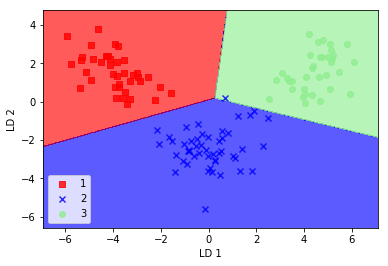

In [69]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

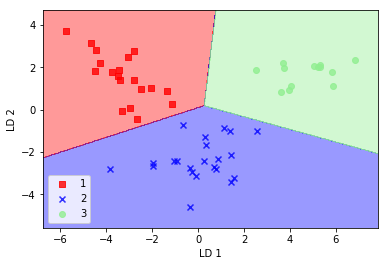

In [61]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()